# Airline customer satisfaction analysis

Imported libraries

In [23]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns


import plotly.express as px
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, precision_recall_fscore_support
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import os

%matplotlib inline 

## Loading the data and visualizing it

In [2]:
directory = "./dataset/"
feature_tables = ['train.csv', 'test.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]

# Create dataframes
print(f'Reading csv from {df_train}...')
train = pd.read_csv(df_train)
print('...Complete')

print(f'Reading csv from {df_train}...')
test = pd.read_csv(df_test)
print('...Complete')

Reading csv from ./dataset/train.csv...
...Complete
Reading csv from ./dataset/train.csv...
...Complete


The dataset is given in two sets: train and test. We are concatenating them so we can implement our own techniques of validation

In [3]:
#Concatenating the two datasets

datasets = [train, test]
df_dataset = pd.concat(datasets)

In [4]:
df_dataset.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
# Retrieving some information about the dataset

df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

## Data cleansing

From the ```info``` we can see: 

1. There are  columns in which the data should be categorical and needs to be converted;

2. We can also see that the dataset has some missing data and it needs to be cleaned;

3. We need to drop the first two columns, irrelevant for the problem (id columns).

In [6]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    return df


df_dataset.dropna(inplace=True)
data = process_data(df_dataset)

## Overviewing the data

We can get information about the data using the ``desbribe`` method for both quantitative and categorical values.

In [7]:
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [8]:
data.describe()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,...,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,0.507410,0.816862,39.428761,0.690764,1.029910,1190.210662,2.728544,3.057349,2.756786,2.976909,...,3.358067,3.383204,3.351078,3.631886,3.306239,3.642373,3.286222,14.643385,15.091129,0.434499
std,0.499947,0.386781,15.117597,0.462180,0.962638,997.560954,1.329235,1.526787,1.401662,1.278506,...,1.334149,1.287032,1.316132,1.180082,1.266146,1.176614,1.313624,37.932867,38.465650,0.495693
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.000000,1.000000,1.000000,844.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,51.000000,1.000000,2.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


We can check the distribution of customer's satisfaction within the data  

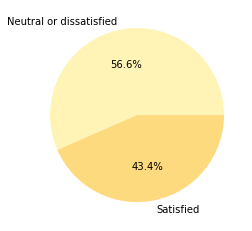

In [9]:
plt.pie(data.satisfaction.value_counts(),
        labels = ["Neutral or dissatisfied",
        "Satisfied"],
        colors = sns.color_palette("YlOrBr"),
        autopct = '%1.1f%%')
pass

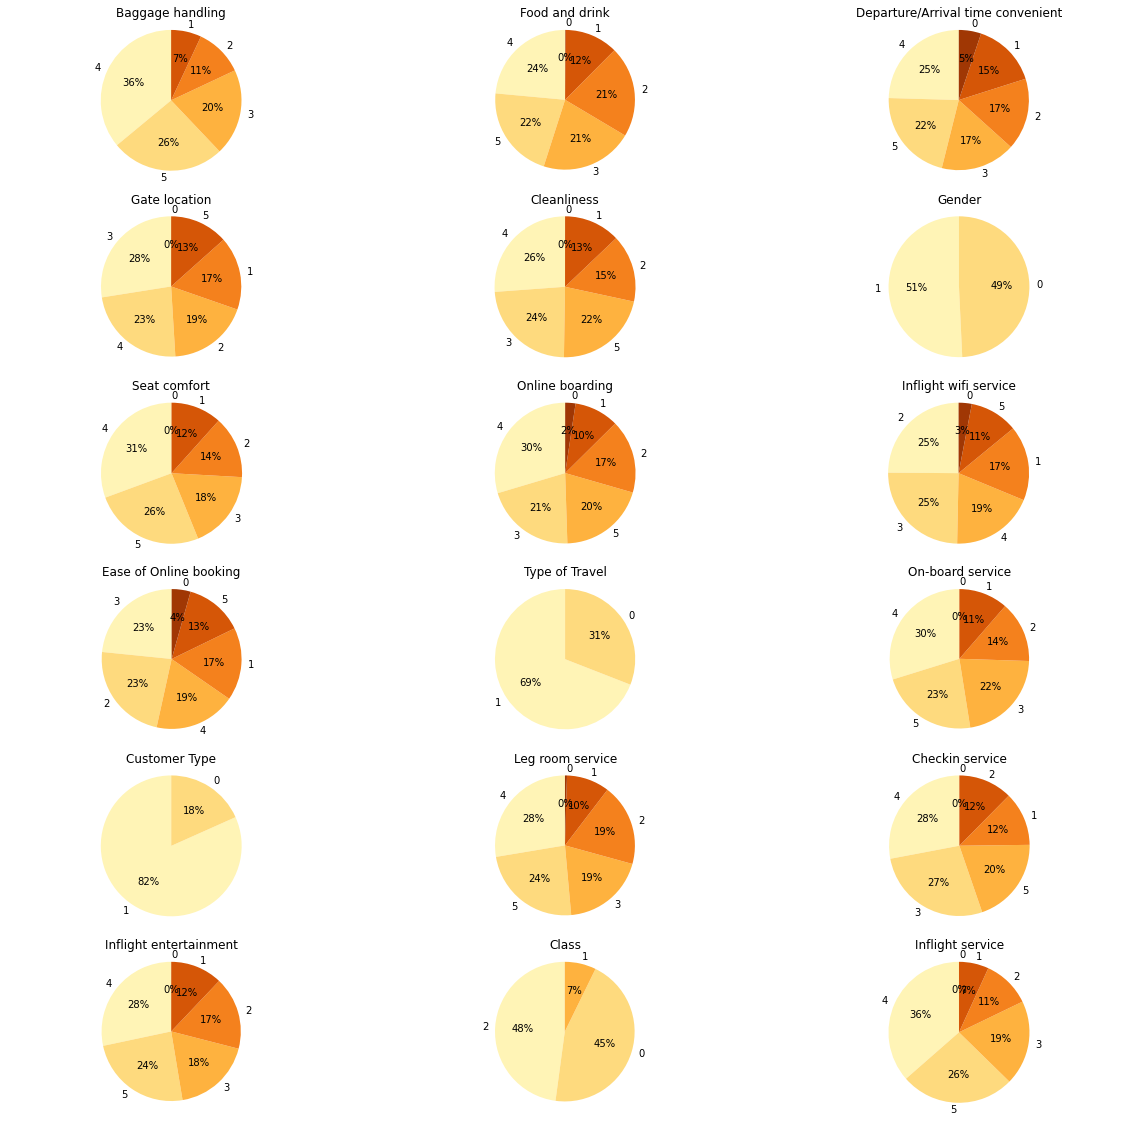

In [10]:
# Retrieving categorical indexes

numerical_columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
categorical_columns = set(data.columns) ^ set(numerical_columns)
categorical_columns.remove('satisfaction')

fig, axes = plt.subplots(6, 3, figsize = (20, 20))

for i, col in enumerate(categorical_columns):
    column_values = data[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    # axes[i//3, i%3].barh(y =sizes, width = 0.5, color = sns.color_palette("YlOrBr"))
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

```
From these graphs we can see that:
- The dataset is balanced between genders : women and men
- There are far more answers from loyal customers than from disloyal
- The majority of travels are 'Business travels'
- And most of the evaluations have the ``0 score`` being less than 5% 
```

We can also check for the correlation between the features

C:\Users\renan\AppData\Local\Temp\ipykernel_4952\1711578135.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

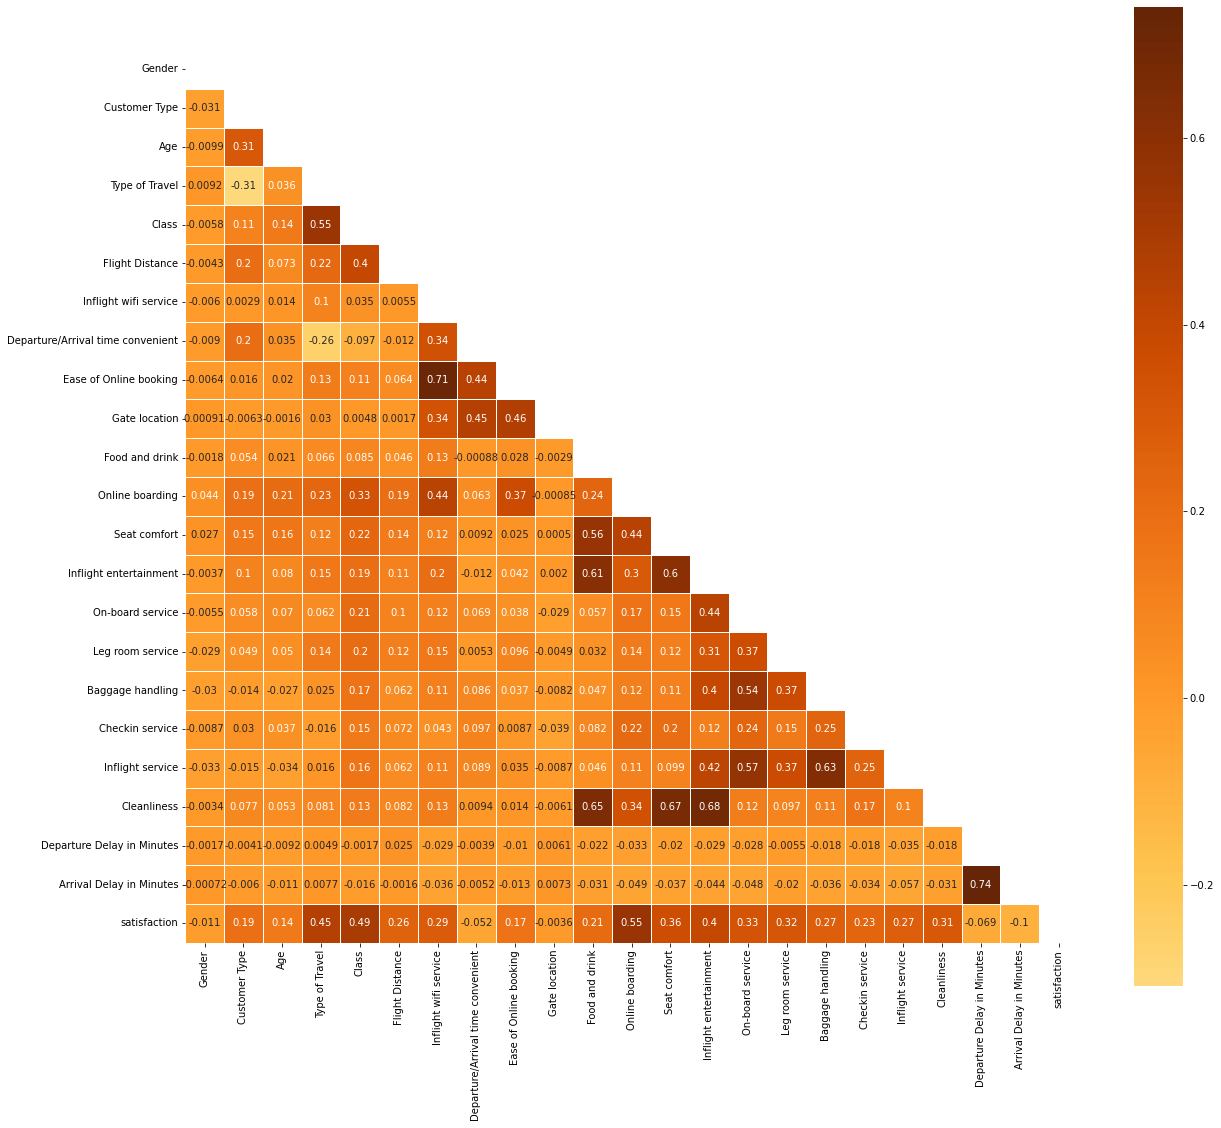

In [11]:
corr = data.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlOrBr", center=0,
            square=True, linewidths=.5)

### Creating a K-fold for cross validation

In [30]:
X = data.iloc[:, 0:-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()

skf = StratifiedKFold(n_splits=4,random_state=42, shuffle=True)

skf.get_n_splits(X,y)


print(skf)
for train_index, test_index in skf.split(X,y):
    X[train_index] = scaler.fit_transform(X[train_index])
    X[test_index]= scaler.fit_transform(X[test_index])

StratifiedKFold(n_splits=4, random_state=42, shuffle=True)


## Models Evaluation

Once the data is ready, we can now train different models and compare the results to see which one fits the problem the best.

We'll be looking at the ROC_AUC metric, as well as the confusion matrix and the metric extracted from it, such as precision and recall.

At the end, we'll rank the models by accuracy.

In [13]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = precision_recall_fscore_support(y_test,y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5,target_names=["Neutral/Dissatisfied","Satisfied"]))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=model.classes_,display_labels=["Neutral/Dissatisfied","Satisfied"], normalize='all',cmap='YlOrBr')
    plt.show()
    return model, roc_auc, report

### Gaussian Naive Bayes

------------------ Resultado 1º fold --------------------
ROC_AUC = 0.8590155071248411
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86722   0.89673   0.88173     36613
           Satisfied    0.85936   0.82130   0.83990     28131

            accuracy                        0.86396     64744
           macro avg    0.86329   0.85902   0.86081     64744
        weighted avg    0.86381   0.86396   0.86355     64744



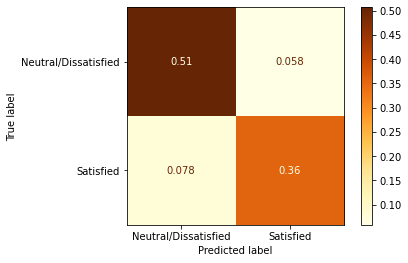

------------------ Resultado 2º fold --------------------
ROC_AUC = 0.8594984044250245
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86688   0.89859   0.88245     36612
           Satisfied    0.86141   0.82041   0.84041     28131

            accuracy                        0.86462     64743
           macro avg    0.86415   0.85950   0.86143     64743
        weighted avg    0.86451   0.86462   0.86418     64743



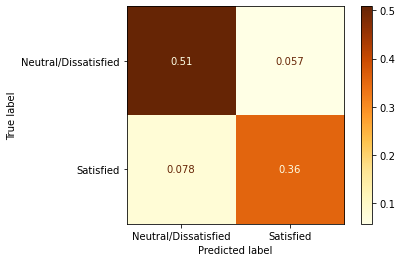

------------------ Resultados agregados --------------------
Média de precisão dos K folds: 0.8637191562948411
---
Média de recall dos K folds: 0.8592569557749328
---
Média de f-scores dos K folds: 0.861122455347002
---
Média de ROC_AUC dos K folds: 0.8592569557749328


In [14]:
params_gnb = {}

precisions_gnb = []
recalls_gnb = []
f_scores_gnb = []
supports_gnb = []
rocs_auc_gnb = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Resultado {index}º fold --------------------")
    model_gnb = GaussianNB(**params_gnb)
    model_gnb, roc_auc_gnb,report_gnb = run_model(model_gnb, X_train, y_train, X_test, y_test)
    precision, recall, f_score, support = report_gnb
    precisions_gnb.append(precision)
    recalls_gnb.append(recall)
    f_scores_gnb.append(f_score)
    supports_gnb.append(support)
    rocs_auc_gnb.append(roc_auc_gnb)
print("------------------ Resultados agregados --------------------")
print(f"Média de precisão dos K folds: {np.mean((precisions_gnb))}\n---")
print(f"Média de recall dos K folds: {np.mean((recalls_gnb))}\n---")
print(f"Média de f-scores dos K folds: {np.mean((f_scores_gnb))}\n---")
print(f"Média de ROC_AUC dos K folds: {np.mean((rocs_auc_gnb))}")
  

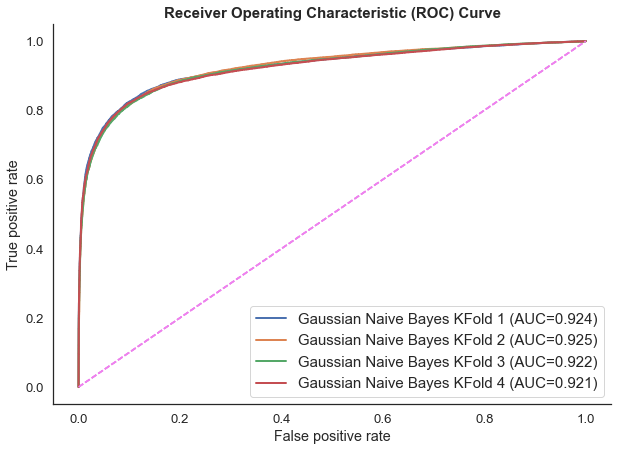

In [32]:
fig = plt.figure(figsize=[10,7])
i = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    fpr, tpr, thresholds = roc_curve(y_test, model_gnb.predict_proba(X_test)[:,1])
    sns.set(style='white',font_scale=1.2)
    plt.plot(fpr, tpr,lw=2,label='Gaussian Naive Bayes KFold {:d} (AUC={:.3f})'.format(i+1, roc_auc_score(y_test, model_gnb.predict_proba(X_test)[:,1])))
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc="lower right",fontsize=15)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15);
    sns.despine()
    plt.savefig('ROCplot.png',transparent=True, bbox_inches='tight')
    i += 1

### KNN

------------------ Resultado 1º fold --------------------
ROC_AUC = 0.9182943990609316
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91277   0.95543   0.93361     36613
           Satisfied    0.93823   0.88116   0.90880     28131

            accuracy                        0.92316     64744
           macro avg    0.92550   0.91829   0.92121     64744
        weighted avg    0.92383   0.92316   0.92283     64744



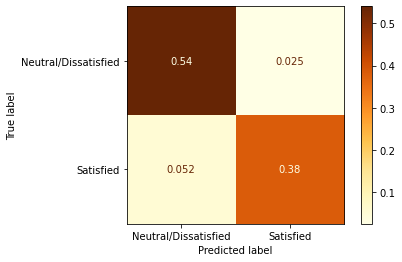

------------------ Resultado 2º fold --------------------
ROC_AUC = 0.917700814379454
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91099   0.95712   0.93348     36612
           Satisfied    0.94025   0.87828   0.90821     28131

            accuracy                        0.92286     64743
           macro avg    0.92562   0.91770   0.92085     64743
        weighted avg    0.92370   0.92286   0.92250     64743



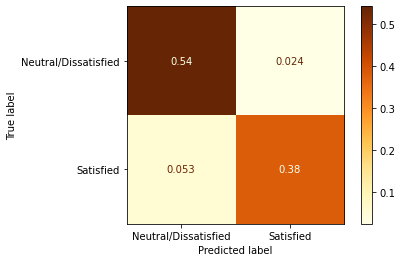

------------------ Resultados agregados --------------------
Média de precisão dos K folds: 0.9255592343435055
---
Média de recall dos K folds: 0.9179976067201929
---
Média de f-scores dos K folds: 0.9210265943895268
---
Média de ROC_AUC dos K folds: 0.9179976067201928


In [15]:
params_kn = {'n_neighbors': 3,
             'metric':'minkowski',
             'p':2}

precisions_knn = []
recalls_knn = []
f_scores_knn = []
supports_knn = []
rocs_auc_knn = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Resultado {index}º fold --------------------")

    model_kn = KNeighborsClassifier(**params_kn)
    model_kn, roc_auc_knn, report_knn = run_model(model_kn, X_train, y_train, X_test, y_test)

    precision, recall, f_score, support = report_knn
    precisions_knn.append(precision)
    recalls_knn.append(recall)
    f_scores_knn.append(f_score)
    supports_knn.append(support)
    rocs_auc_knn.append(roc_auc_knn)
    
print("------------------ Resultados agregados --------------------")
print(f"Média de precisão dos K folds: {np.mean((precisions_knn))}\n---")
print(f"Média de recall dos K folds: {np.mean((recalls_knn))}\n---")
print(f"Média de f-scores dos K folds: {np.mean((f_scores_knn))}\n---")
print(f"Média de ROC_AUC dos K folds: {np.mean((rocs_auc_knn))}")

### Decision Tree

------------------ Resultado 1º fold --------------------
ROC_AUC = 0.9454157836605476
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95021   0.95603   0.95311     36613
           Satisfied    0.94231   0.93481   0.93854     28131

            accuracy                        0.94681     64744
           macro avg    0.94626   0.94542   0.94583     64744
        weighted avg    0.94678   0.94681   0.94678     64744



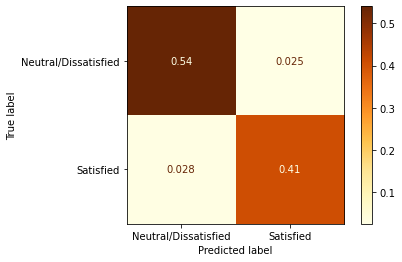

------------------ Resultado 2º fold --------------------
ROC_AUC = 0.9483305901623975
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95014   0.96239   0.95623     36612
           Satisfied    0.95022   0.93427   0.94218     28131

            accuracy                        0.95017     64743
           macro avg    0.95018   0.94833   0.94920     64743
        weighted avg    0.95017   0.95017   0.95012     64743



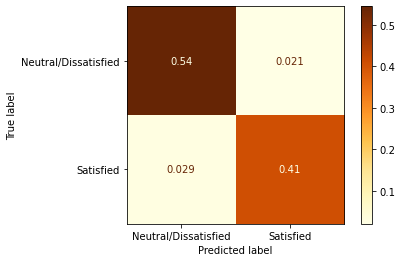

------------------ Resultados agregados --------------------
Média de precisão dos K folds: 0.9482192061046749
---
Média de recall dos K folds: 0.9468731869114725
---
Média de f-scores dos K folds: 0.9475135640560864
---
Média de ROC_AUC dos K folds: 0.9468731869114726


In [16]:
params_dt = {'criterion': 'gini',
             'max_depth': 20,
             'random_state':42}

precisions_dt = []
recalls_dt = []
f_scores_dt = []
supports_dt = []
rocs_auc_dt = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Resultado {index}º fold --------------------")
    model_dt = DecisionTreeClassifier(**params_dt)
    model_dt, roc_auc_dt,report_dt = run_model(model_dt, X_train, y_train, X_test, y_test)
    
    precision, recall, f_score, support = report_dt

    precisions_dt.append(precision)
    recalls_dt.append(recall)
    f_scores_dt.append(f_score)
    supports_dt.append(support)
    rocs_auc_dt.append(roc_auc_dt)
    
print("------------------ Resultados agregados --------------------")
print(f"Média de precisão dos K folds: {np.mean((precisions_dt))}\n---")
print(f"Média de recall dos K folds: {np.mean((recalls_dt))}\n---")
print(f"Média de f-scores dos K folds: {np.mean((f_scores_dt))}\n---")
print(f"Média de ROC_AUC dos K folds: {np.mean((rocs_auc_dt))}")

### Random Forest

------------------ Resultado 1º fold --------------------
ROC_AUC = 0.9596969195035082
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95550   0.97872   0.96697     36613
           Satisfied    0.97140   0.94067   0.95579     28131

            accuracy                        0.96219     64744
           macro avg    0.96345   0.95970   0.96138     64744
        weighted avg    0.96241   0.96219   0.96211     64744



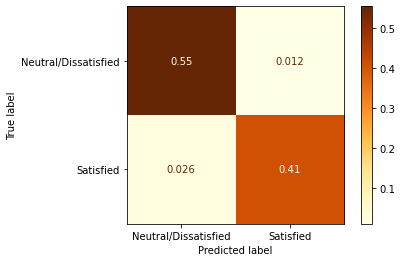

------------------ Resultado 2º fold --------------------
ROC_AUC = 0.9592173386346067
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95553   0.97766   0.96647     36612
           Satisfied    0.97002   0.94078   0.95517     28131

            accuracy                        0.96163     64743
           macro avg    0.96277   0.95922   0.96082     64743
        weighted avg    0.96182   0.96163   0.96156     64743



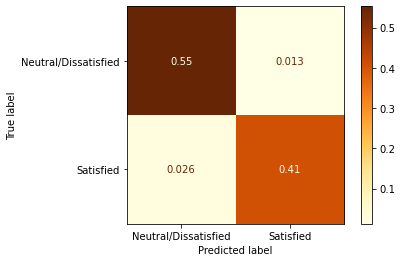

------------------ Resultados agregados --------------------
Média de precisão dos K folds: 0.9631110367646737
---
Média de recall dos K folds: 0.9594571290690576
---
Média de f-scores dos K folds: 0.9610998670839067
---
Média de ROC_AUC dos K folds: 0.9594571290690574


In [17]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

precisions_rf = []
recalls_rf = []
f_scores_rf = []
supports_rf = []
rocs_auc_rf =[]
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Resultado {index}º fold --------------------")

    model_rf = RandomForestClassifier(**params_rf)
    model_rf, roc_auc_rf, report_rf = run_model(model_rf, X_train, y_train, X_test, y_test)
    
    precision, recall, f_score, support = report_rf
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    f_scores_rf.append(f_score)
    supports_rf.append(support)
    rocs_auc_rf.append(roc_auc_rf)
    
print("------------------ Resultados agregados --------------------")
print(f"Média de precisão dos K folds: {np.mean((precisions_rf))}\n---")
print(f"Média de recall dos K folds: {np.mean((recalls_rf))}\n---")
print(f"Média de f-scores dos K folds: {np.mean((f_scores_rf))}\n---")
print(f"Média de ROC_AUC dos K folds: {np.mean((rocs_auc_rf))}")

## Model Comparison and Conclusions

Based on _________ we have a clean winner. Our Random forest classifier outperformed all of our other models.

In [18]:
models = {'Gaussian NB':'gnb','KNN': 'knn','Decision Trees':'dt','Random Forest':'rf'}
model_list = []

for model,model_abv in models.items():
    model_dic = {'Model': model,'AUC':np.mean(eval('rocs_auc_{0}'.format(model_abv))),
     'Precision':np.mean(eval('precisions_{0}'.format(model_abv))),
     'Recal':np.mean(eval('recalls_{0}'.format(model_abv))),
     'F-score': np.mean(eval('f_scores_{0}'.format(model_abv))) }
    model_list.append(model_dic)


In [19]:
model_df = pd.DataFrame(model_list)
model_df

,Model,AUC,Precision,Recal,F-score
0,Gaussian NB,0.859257,0.863719,0.859257,0.861122
1,KNN,0.917998,0.925559,0.917998,0.921027
2,Decision Trees,0.946873,0.948219,0.946873,0.947514
3,Random Forest,0.959457,0.963111,0.959457,0.961100


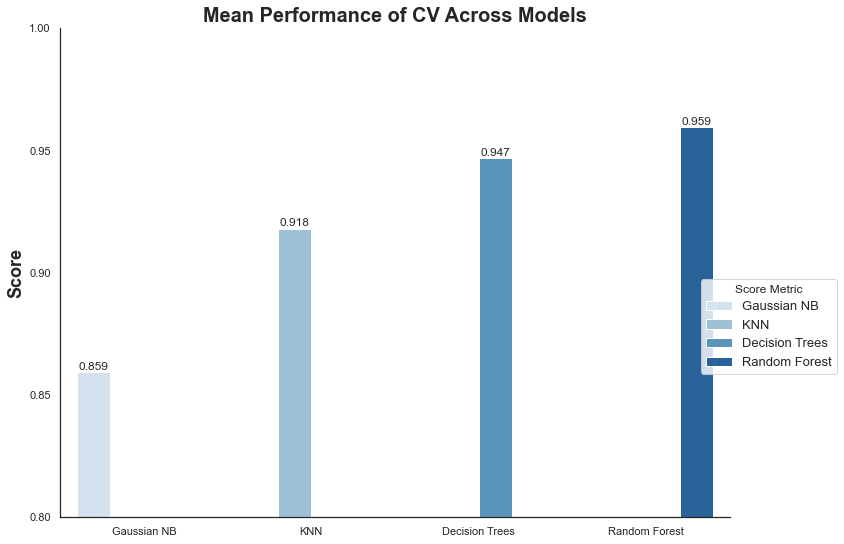

In [20]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='AUC',data=model_df,hue='Model',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of CV Across Models',weight='bold',fontsize=20)
sns.despine()
plt.savefig('modelbarplot.png',transparent=True, bbox_inches='tight')